# Evaluation Analysis of Trained Models

## Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from typing import List, Optional
from mpl_toolkits.mplot3d import Axes3D

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import constants, common
from utils.dataset_loader import PolicyDatasetLoader

from optimization import functions
from optimization.updater import Updater

from environment.environment import RobotEnvironment
from environment.buffer import ReplayBuffer

from models.policy_model import RobotPolicy
from models.reward_model import RewardFunction

In [2]:
pd.set_option("display.max_columns",
              None)

## Functions

In [3]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae_avg = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        mae_max = np.max(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"Avg. MAE = {mae_avg:.5f} m\nMax. MAE = {mae_max:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend(loc="upper right")
    
    plt.show()

In [4]:
def plot_3D_vector(ax: Axes3D,
                   list_trajectory: List[torch.Tensor],
                   color: str,
                   traj_s: int,
                   start_s: int,
                   end_s: int,
                   label: str,
                   env: Optional[RobotEnvironment] = None) -> None:

    if not isinstance(list_trajectory, list):
        raise TypeError("list_trajectory should be a list of torch.Tensor")
    if not all(isinstance(position, torch.Tensor) for position in list_trajectory):
        raise TypeError("Each element in list_trajectory should be a torch.Tensor")
    
    state_1 = [object_dist[0].item() for object_dist in list_trajectory]
    state_2 = [target_dist[1].item() for target_dist in list_trajectory]
    state_3 = [ground_dist[2].item() for ground_dist in list_trajectory]
    
    scatter_traj = ax.scatter(state_1, state_2, state_3,
                              c=color, marker="o", s=traj_s, label=label)
    
    scatter_start = ax.scatter(state_1[0], state_2[0], state_3[0],
                               c="green", marker="*", s=start_s, label="Start Position")
    scatter_end = ax.scatter(state_1[-1], state_2[-1], state_3[-1],
                             c="blue", marker="X", s=end_s, label="End Position")
    
    # do not specify environment object when the input is state vector
    if env is not None:
        target_location_normalized = common.normalize_action(action=np.array(constants.TARGET_LOCATION).reshape((1, len(constants.TARGET_LOCATION))),
                                                             norm_range_list=env.action_norms)[0]
        scatter_target = ax.scatter(target_location_normalized[0], target_location_normalized[1], target_location_normalized[2],
                                    c="black", marker="+", s=end_s, label="Target Location")

## Initialization

In [5]:
# available training machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device: ", device)

configs = functions.setup_config(device=device)

Training Device:  cpu
Current Time:  Feb_20_2024-14_31_18


## Load Dataset

In [6]:
# create and return preliminary base paths
json_paths, results_path = functions.get_directories(parent_directory=parent_directory,
                                                     data_folder_name=constants.TEST_COLLECTION_DATE)

# load test demonstrations dataset
all_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)

# get all indice numbers where the new trajectory is initialized in the dataset
trajectory_indices = functions.find_indices_of_trajectory_changes(dataset=all_data)


================== Policy Dataset Loader ==================

Number of Trajectories:  5
Each Trajectory Length:  20
Full Demo Dataset Size:  107


## Create and Load Pre-Trained Reward and Policy Models and Parameters

In [7]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             device=configs.device)
reward_network = RewardFunction(state_size=configs.state_size,
                                hidden_size=configs.hidden_size,
                                out_size=configs.reward_size,
                                device=configs.device)

In [8]:
# folder name where policy model parameters are located ("results / policy_network_params / loading_folder_name")
policy_loading_folder_name = constants.POLICY_LOADING_FOLDER
policy_params_name = constants.POLICY_PARAMS_NAME

# folder name where reward model parameters are located ("results / reward_network_params / loading_folder_name")
reward_loading_folder_name = constants.REWARD_LOADING_FOLDER
reward_params_name = constants.REWARD_PARAMS_NAME

# load pretrained policy network parameters if the pre-trained model is available
policy_network = functions.load_policy_from_path(policy_network=policy_network,
                                                 results_path=results_path,
                                                 policy_loading_folder_name=policy_loading_folder_name,
                                                 policy_params_name=policy_params_name)

# load pretrained reward network parameters if the pre-trained model is available
reward_network = functions.load_reward_from_path(reward_network=reward_network,
                                                 results_path=results_path,
                                                 reward_loading_folder_name=reward_loading_folder_name,
                                                 reward_params_name=reward_params_name)

In [9]:
# model loss functions
updater_obj = Updater(configs=configs,
                      policy_network=policy_network,
                      reward_network=reward_network)

## Environment Setup

In [10]:
# construct custom environment for reward function training
env = RobotEnvironment()
env.set_reward_network(reward_network)
env.is_reward_inference = True

# create a replay buffer class object
replay_buffer = ReplayBuffer(capacity=configs.replay_buffer_capacity)

## Test Trained Models on Demonstration Dataset Samples Individually

In [11]:
# initialize empty tensors for demonstration and sample trajectories
trajectory_dataframes = []
data_demo_tensor, data_robo_tensor = torch.tensor([]), torch.tensor([])

# get list of demonstration trajectories for training and analysis
for traj_start_index in range(len(trajectory_indices)):
    traj_df, _, _, _ = functions.get_estimated_rewards(configs=configs,
                                                       updater_obj=updater_obj,
                                                       data_loader=all_data,
                                                       policy_network=policy_network,
                                                       reward_network=reward_network,
                                                       trajectory_indices=trajectory_indices,
                                                       traj_start_index=traj_start_index,
                                                       is_inference_reward=True,
                                                       is_inference_policy=True,
                                                       is_deterministic=True)
    trajectory_dataframes.append(traj_df)
    del traj_df

In [12]:
# choose one trajectory to analyze out of human demonstrations
test_traj = trajectory_dataframes[-1]
test_traj

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,action_label_norm_1,action_label_norm_2,action_label_norm_3,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,action_pred_logprob_1,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,next_state_label_norm_1,next_state_label_norm_2,next_state_label_norm_3,next_state_label_denorm_1,next_state_label_denorm_2,next_state_label_denorm_3,next_state_est_norm_1,next_state_est_norm_2,next_state_est_norm_3,next_state_est_denorm_1,next_state_est_denorm_2,next_state_est_denorm_3
0,0.238033905625,0.558691918850,0.260900944471,0.714101716876,1.676075756550,0.782702833414,-0.199939355254,-0.355767905712,-0.385758787394,-0.399878740311,-0.711535811424,0.614241242409,6.546385288239,-0.281299084425,-0.290755510330,-0.356632143259,0.060323476791,0.040392544121,0.037401031703,-0.562598228455,-0.581511020660,0.643367886543,4,0,-4.038350582123,0.238033905625,0.558691918850,0.260900944471,0.714101716876,1.676075756550,0.782702833414,0.238027130323,0.558691181545,0.260913747470,0.714081390970,1.676073544636,0.782741242409,0.203464403163,0.529859262901,0.270622628848,0.610393209490,1.589577788704,0.811867886543
1,0.238027125597,0.558691143990,0.260913729668,0.714081376791,1.676073431969,0.782741189003,-0.213343515992,-0.352634400129,-0.387589663267,-0.426687002182,-0.705268859863,0.612410306931,6.298463344574,-0.275389701128,-0.238995924592,-0.341596007347,0.065463937819,0.043607447296,0.040905285627,-0.550779342651,-0.477991819382,0.658403992653,4,1,-1.821710586548,0.203464403749,0.529859244823,0.270622640848,0.610393211246,1.589577734470,0.811867922544,0.236062168067,0.556844908850,0.260303435644,0.708186504202,1.670534726551,0.780910306931,0.170655853579,0.503062902174,0.275634664218,0.511967560738,1.509188706521,0.826903992653
2,0.236062154174,0.556844890118,0.260303437710,0.708186462522,1.670534670353,0.780910313129,-0.236339330673,-0.338312327862,-0.389600485563,-0.472678661346,-0.676624655724,0.610399484634,6.068642139435,-0.270728915930,-0.191132098436,-0.331662207842,0.070424154401,0.046780481935,0.044603202492,-0.541457891464,-0.382264137268,0.668337821960,4,2,-0.156498908997,0.170655846596,0.503062903881,0.275634676218,0.511967539787,1.509188711643,0.826904028654,0.227616640286,0.548948872587,0.259633161545,0.682849920858,1.646846617762,0.778899484634,0.141110415093,0.478532147843,0.278945940653,0.423331245279,1.435596443529,0.836837821960
3,0.227616637945,0.548948884010,0.259633183479,0.682849913836,1.646846652031,0.778899550438,-0.265253275633,-0.317788839340,-0.391004770994,-0.530506610870,-0.635577678680,0.608995199203,5.862504959106,-0.266843348742,-0.146759316325,-0.324842929840,0.075068928301,0.049792636186,0.048311594874,-0.533686637878,-0.293518662453,0.675157070160,4,3,0.974507331848,0.141110420227,0.478532135487,0.278945952654,0.423331260681,1.435596406460,0.836837857962,0.217054891433,0.538435996397,0.259165066401,0.651164674298,1.615307989190,0.777495199203,0.114844996024,0.456191510174,0.281219023387,0.344534988071,1.368574530522,0.843657070160
4,0.217054873705,0.538435995579,0.259165078402,0.651164621115,1.615307986736,0.777495235205,-0.287953138351,-0.285823434591,-0.390353143215,-0.575906276703,-0.571646928787,0.609646856785,5.678886890411,-0.263376682997,-0.106013745070,-0.319984614849,0.079389773309,0.052614517510,0.051945827901,-0.526753425598,-0.212027549744,0.680015385151,4,4,1.126194953918,0.114844992757,0.456191509962,0.281219035387,0.344534978271,1.368574529886,0.843657106161,0.200227593294,0.521977493402,0.259382285595,0.600682779881,1.565932480207,0.778146856785,0.092437360200,0.436165510410,0.282838461717,0.277312

## Visualize Human Demonstration vs. Trained Policy Execution Trajectory

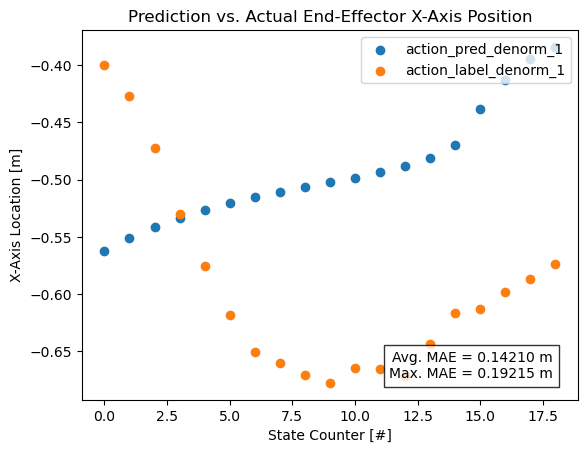

In [13]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

plt_2D_plotting(df=test_traj,
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)

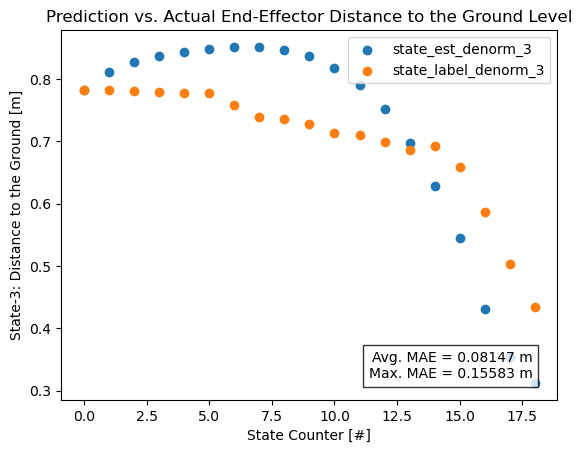

In [14]:
state_3_columns = [constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_3",
                    constants.STATE_DENORMALIZED_LABEL_NAME + "_3"]
state_3_title_name = "Prediction vs. Actual End-Effector Distance to the Ground Level"
state_3_y_axis_name = "State-3: Distance to the Ground [m]"

plt_2D_plotting(df=test_traj,
                column_names=state_3_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=state_3_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=state_3_title_name)

## Test Models on Trained Policy Generated Trajectories

In [15]:
episodes_to_run = 10

# create episodes of trajectories by running trained policy model
# take deterministic actions for behavior cloning by setting is_deterministic=True to use mean actions from distribution
robot_trajectories = [functions.generate_session(env=env,
                                                 t_max=constants.TRAJECTORY_SIZE,
                                                 updater_obj=updater_obj,
                                                 replay_buffer=replay_buffer,
                                                 policy_network=policy_network,
                                                 is_policy_inference=True,
                                                 is_policy_gradient_update=False,
                                                 is_deterministic=True) for _ in range(episodes_to_run)]

In [16]:
# choose one randomly initialized state robot trajectory to analyze
robot_trajectory = robot_trajectories[-1]

state_tensor_list = robot_trajectory[0]
action_tensor_list = robot_trajectory[1]
reward_tensor_list = robot_trajectory[3]

## Visualize Randomly Initialized State Trajectory Execution of Trained Policy

<IPython.core.display.Javascript object>


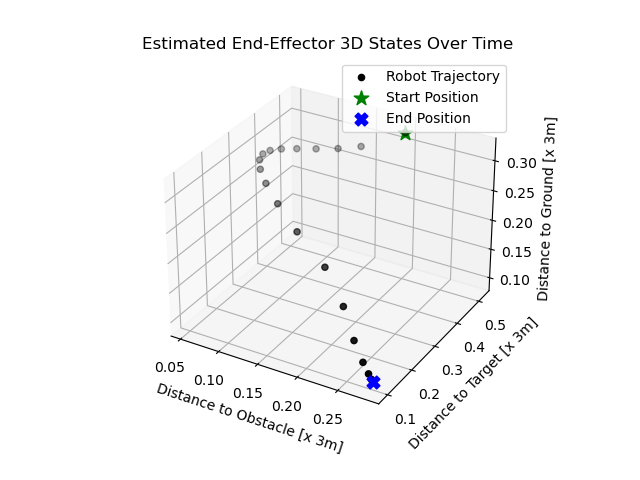

In [17]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

plot_3D_vector(ax=ax,
               list_trajectory=state_tensor_list,
               color="black",
               traj_s=20,
               start_s=120,
               end_s=85,
               label="Robot Trajectory")

ax.set_xlabel("Distance to Obstacle [x 3m]")
ax.set_ylabel("Distance to Target [x 3m]")
ax.set_zlabel("Distance to Ground [x 3m]")
ax.set_title("Estimated End-Effector 3D States Over Time")

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


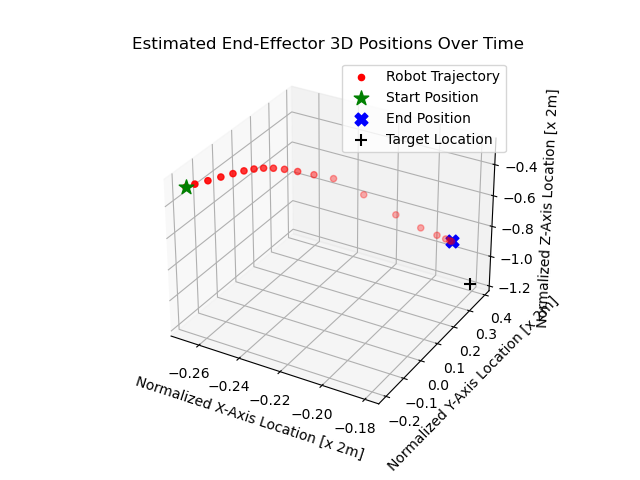

In [18]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

plot_3D_vector(env=env,
               ax=ax,
               list_trajectory=action_tensor_list,
               color="red",
               traj_s=20,
               start_s=120,
               end_s=85,
               label="Robot Trajectory")

ax.set_xlabel("Normalized X-Axis Location [x 2m]")
ax.set_ylabel("Normalized Y-Axis Location [x 2m]")
ax.set_zlabel("Normalized Z-Axis Location [x 2m]")
ax.set_title("Estimated End-Effector 3D Positions Over Time")

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


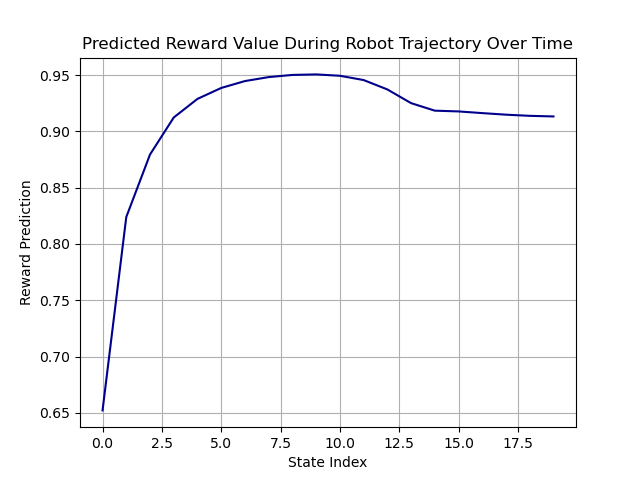

In [19]:
rewards = [reward_tensor[0].item() for reward_tensor in reward_tensor_list]

fig = plt.figure()
plt.plot(rewards, c="darkblue")
plt.xlabel("State Index")
plt.ylabel("Reward Prediction")
plt.title("Predicted Reward Value During Robot Trajectory Over Time")
plt.grid()
plt.show()

## Reset the Model Parameters and Examine the Output of Reward Function

In [20]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             device=configs.device)

In [21]:
unlearned_robot_trajectory = [functions.generate_session(env=env,
                                                         t_max=constants.TRAJECTORY_SIZE,
                                                         updater_obj=updater_obj,
                                                         replay_buffer=replay_buffer,
                                                         policy_network=policy_network,
                                                         is_policy_inference=True,
                                                         is_policy_gradient_update=False,
                                                         is_deterministic=True) for _ in range(episodes_to_run)][0]
dummy_state_tensor_list = unlearned_robot_trajectory[0]
dummy_action_tensor_list = unlearned_robot_trajectory[1]
dummy_reward_tensor_list = unlearned_robot_trajectory[3]

## Visualize Randomly Initialized State Trajectory Execution of Not Trained Policy

<IPython.core.display.Javascript object>


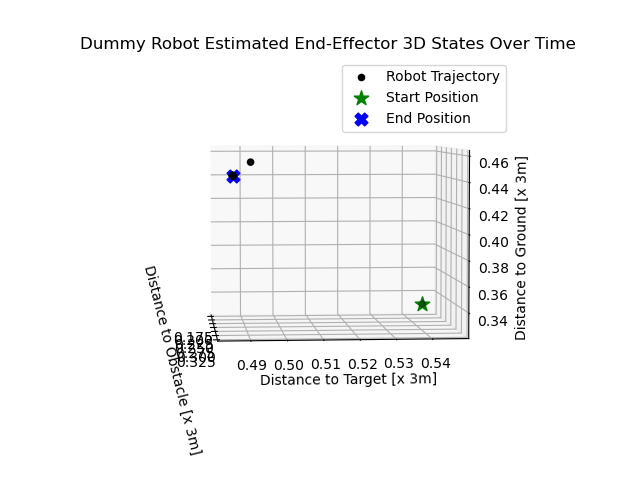

In [22]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

plot_3D_vector(ax=ax,
               list_trajectory=dummy_state_tensor_list,
               color="black",
               traj_s=20,
               start_s=120,
               end_s=85,
               label="Robot Trajectory")

ax.set_xlabel("Distance to Obstacle [x 3m]")
ax.set_ylabel("Distance to Target [x 3m]")
ax.set_zlabel("Distance to Ground [x 3m]")
ax.set_title("Dummy Robot Estimated End-Effector 3D States Over Time")

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


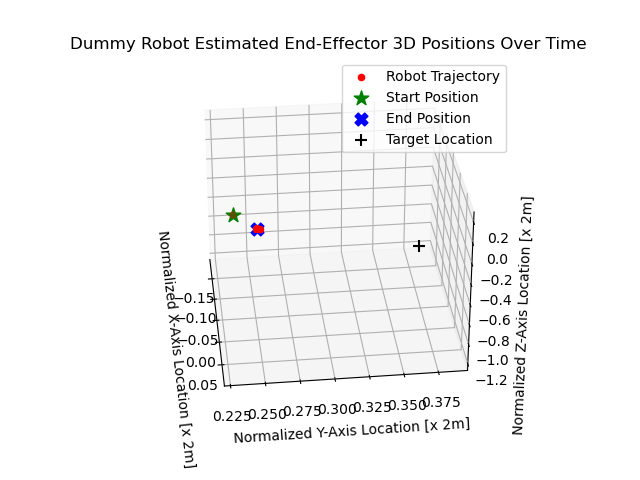

In [23]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

plot_3D_vector(env=env,
               ax=ax,
               list_trajectory=dummy_action_tensor_list,
               color="red",
               traj_s=20,
               start_s=120,
               end_s=85,
               label="Robot Trajectory")

ax.set_xlabel("Normalized X-Axis Location [x 2m]")
ax.set_ylabel("Normalized Y-Axis Location [x 2m]")
ax.set_zlabel("Normalized Z-Axis Location [x 2m]")
ax.set_title("Dummy Robot Estimated End-Effector 3D Positions Over Time")

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


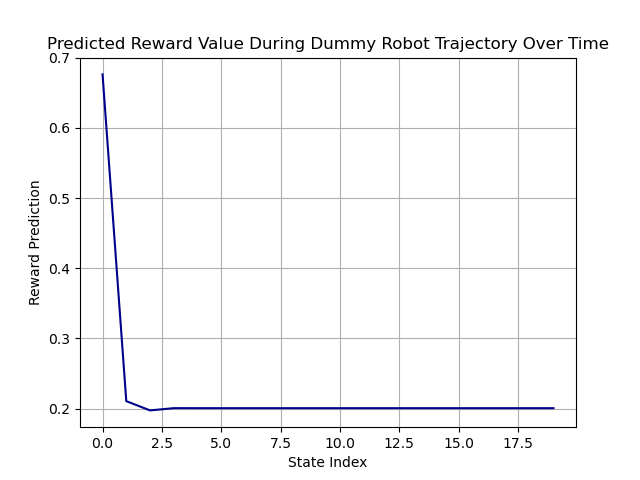

In [26]:
dummy_rewards = [dummy_reward_tensor[0].item() for dummy_reward_tensor in dummy_reward_tensor_list]

fig = plt.figure()
plt.plot(dummy_rewards, c="darkblue")
plt.xlabel("State Index")
plt.ylabel("Reward Prediction")
plt.title("Predicted Reward Value During Dummy Robot Trajectory Over Time")
plt.grid()
plt.show()